In [3]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ USA Vaccines ](#build_USA_Vaccines)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [4]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [5]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [6]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [7]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [8]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [9]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

Date   FIPS       Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
0        2021-11-14  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0
1        2021-11-14  21219        Todd County          KY                      38.3                    4705            43.0            5282.0
2        2021-11-14  26047       Emmet County          MI                      68.5                   22875            72.2           24135.0
3        2021-11-14  40079    Le Flore County          OK                      35.5                   17684            40.6           20247.0
4        2021-11-14  16057       Latah County          ID                      50.1                   20098            56.0           22467.0
...             ...    ...                ...         ...                       ...                     ...             ...               ...
1109340  2020-12-13  55023    Crawford County          WI                       0.0                       0             0.0               0.0
1109341  2020-12-13  47153  Sequatchie County          TN                       0.0                       0             0.0               0.0
1109342  2020-12-13  34015  Gloucester County          NJ                       0.0                       0             0.0               0.0
1109343  2020-12-13  45061         Lee County          SC                       0.0                       0             0.0               0.0
1109344  2020-12-13  26061    Houghton County          MI                       0.0                       0             0.0               0.0

[1050711 rows x 8 columns]

<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [10]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [11]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [12]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [13]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

state        Date  short_staffed  got_covid_at_hosp  total_beds  beds_used  covid_beds_used  icu_occupancy  covid_icu  covid_beds_adult  covid_beds_kids  icu_total  beds_used_pct  \
25388    NC  2020-01-01            0.0                0.0        72.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
25607    TX  2020-01-01            0.0                0.0       790.0       42.0              0.0            NaN        NaN               NaN              NaN        NaN       0.656250   
31945    MT  2020-01-01            0.0                0.0        36.0       12.0              0.0            NaN        NaN               NaN              NaN        NaN       0.333333   
28150    PR  2020-01-01            0.0                0.0       146.0       61.0              0.0            NaN        NaN               NaN              NaN        NaN       0.417808   
29086    HI  2020-01-01            0.0                0.0         0.0        0.0              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
...     ...         ...            ...                ...         ...        ...              ...            ...        ...               ...              ...        ...            ...   
18204    DC  2021-11-15            0.0                0.0      3414.0     2548.0             62.0          240.0       12.0              57.0              5.0      332.0       0.746339   
22338    NM  2021-11-15           25.0                1.0      4056.0     2918.0            581.0          371.0      166.0             572.0              9.0      419.0       0.751868   
19543    UT  2021-11-15            1.0                0.0      5509.0     3488.0            541.0          455.0      203.0             522.0             19.0      621.0       0.633146   
13378    MA  2021-11-15           18.0               10.0     16535.0    13735.0            495.0         1032.0      128.0             486.0              9.0     1297.0       0.830662   
17285    WI  2021-11-15           40.0                8.0     11751.0     8269.0           1174.0          974.0      296.0            1147.0             27.0     1461.0       0.703685   

       covid_patients_pct  covid_beds_pct  icu_used  icu_used_pct  therapy_a  therapy_b  therapy_b  
25388                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
25607            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
31945            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
28150            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
29086                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
...                   ...             ...       ...           ...        ...        ...        ...  
18204            0.025275        0.018885  0.038585      0.722892      442.0      320.0      292.0  
22338            0.171859        0.147126  0.417085      0.936869      223.0        0.0       69.0  
19543            0.157405        0.099577  0.332242      0.732689      460.0      248.0       77.0  
13378            0.036349        0.030183  0.100708      0.795682     1732.0        0.0     2500.0  
17285            0.145064        0.102167  0.212644      0.666667     4358.0     2139.0     2666.0  

[33437 rows x 20 columns]

<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [14]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.2
72.0


level_0  index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  \
0          0      0 2020-12-28  total_40     4157971                       0                 0       262150       3045       3040          65     5152.357143        76.357143     123.915177   
1          1      0 2020-12-29  total_40     4157971                       0                 0       265220       3082       5095         101     5085.214286        77.142857     122.300379   
2          2      0 2020-12-30  total_40     4157971                       0                 0       268222       3126       6072          81     5074.285714        75.428571     122.037545   
3          3      0 2020-12-31  total_40     4157971                       0                 0       270820       3212       5600         130     5033.928571        75.642857     121.066948   
4          4      0 2021-01-01  total_40     4157971                       0                 0       273306       3235       5084         109     4917.285714        74.928571     118.261665   
..       ...    ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...   
317      317      0 2021-11-10  total_40     4157971                 1789037           2069918       685026       9593       3316         124     3634.214286        82.571429      87.403551   
318      318      0 2021-11-11  total_40     4157971                 1790736           2072497       686059       9611       3025          64     3488.428571        77.928571      83.897376   
319      319      0 2021-11-12  total_40     4157971                 1790979           2073356       688924       9643       3898          50     3422.857143        73.428571      82.320371   
320      320      0 2021-11-13  total_40     4157971                 1792606           2076044       689737       9653       3678          42     3416.428571        73.142857      82.165762   
321      321      0 2021-11-14  total_40     4157971                 1794134           2077912       690407       9653       1483          10     3380.071429        73.571429      81.291366   

     death_avg_100k  total_vaccinated_percent  first_dose_pct  
0          1.836404                  0.000000        0.000000  
1          1.855301                  0.000000        0.000000  
2          1.814072                  0.000000        0.000000  
3          1.819225                  0.000000        0.000000  
4          1.802047                  0.000000        0.000000  
..              ...                       ...             ...  
317        1.985859                  0.430267        0.497819  
318        1.874197                  0.430675        0.498440  
319        1.765971                  0.430734        0.498646  
320        1.759100                  0.431125        0.499293  
321        1.769407                  0.431493        0.499742  

[322 rows x 17 columns]

- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [15]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [16, 54, 56], 'state': ['ID', 'WV', 'WY']}, 45: {'FIPS': [1, 5, 13, 22, 28, 38, 47], 'state': ['AL', 'AR', 'GA', 'LA', 'MS', 'ND', 'TN']}, 50: {'FIPS': [4, 18, 20, 21, 26, 29, 30, 32, 37, 39, 40, 45, 46, 48, 49], 'state': ['AZ', 'IN', 'KS', 'KY', 'MI', 'MO', 'MT', 'NV', 'NC', 'OH', 'OK', 'SC', 'SD', 'TX', 'UT']}, 55: {'FIPS': [19, 31, 55], 'state': ['IA', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 10, 12, 17, 27, 33, 35, 41, 42, 51, 53], 'state': ['CA', 'CO', 'DE', 'FL', 'IL', 'MN', 'NH', 'NM', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 34, 36], 'state': ['MD', 'NJ', 'NY']}, 70: {'FIPS': [9, 23, 25, 44, 50], 'state': ['CT', 'ME', 'MA', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
5983    4157971 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5984    4157971 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5985    4157971 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5986    4157971 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5987    4157971 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3973   13485352 2021-11-10     32404     1607201      7152         81     6119.285714     45.377278        48.714286       0.361239  CT  [9, 23, 25, 44, 50]  total_70    33189.0   28050.0   
3974   13485352 2021-11-11     32410     1609107      5769         36     5978.714286     44.334877        43.571429       0.323102  CT  [9, 23, 25, 44, 50]  total_70    33342.0   28162.0   
3975   13485352 2021-11-12     32433     1614818      7617         29     6057.428571      44.91858        37.000000       0.274372  CT  [9, 23, 25, 44, 50]  total_70    33333.0   28075.0   
3976   13485352 2021-11-13     32443     1616076      6969         33     6438.000000     47.740689        35.142857         0.2606  CT  [9, 23, 25, 44, 50]  total_70    33227.0   27656.0   
3977   13485352 2021-11-14     32443     1616387      1569         10     6466.857143     47.954678        36.000000       0.266956  CT  [9, 23, 25, 44, 50]  total_70    33183.0   27367.0   

     covid_beds_used icu_total            icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
5983             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5984             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5985             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5986             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5987             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                 ...       ...              ...             ...              ...               ...  
3973          1155.0    2931.0   0.676863184429305     293.0           1140.0            15.0        45.377278          0.361239  
3974          1170.0    2924.0   0.618018181102465     283.0           1159.0            11.0        44.334877          0.323102  
3975          1182.0    2925.0  0.6315809232581641     291.0           1166.0            16.0         44.91858          0.274372  
3976          1178.0    2912.0   0.629324769381803     286.0           1169.0             9.0        47.740689            0.2606  
3977          1206.0    2908.0   0.611212613505661     285.0           1195.0            11.0        47.954678          0.266956  

[4529 rows x 23 columns]

<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [16]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849      968563      16521       15589        104    21784.285714   
335  2020-12-22  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849      981752      16720       19945        244    21887.428571   
336  2020-12-23  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849      993854      16901       25291        380    22036.285714   
337  2020-12-24  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849     1007761      17069       26009        349    22209.000000   
338  2020-12-25  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849     1015400      17161       21546        260    21502.714286   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
658  2021-11-10  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1447838      23468        1815         16     2326.000000   
659  2021-11-11  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1448495      23469        1643          8     2300.714286   
660  2021-11-12  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       263.857143    125.349416       1.518266              100          1.518266                      0.0                      0            0.0              0.0  total_30  
335       263.571429    125.942912       1.516622              100          1.516622                      0.0                      0            0.0              0.0  total_30  
336       267.714286    126.799454        1.54046              100           1.54046                      0.0                      0            0.0              0.0  total_30  
337       266.714286    127.793273       1.534706              100          1.534706                      0.0                      0            0.0              0.0  total_30  
338       261.000000     123.72922       1.501826              100          1.501826                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
658        16.857143     22.229488       0.161103        22.229488          0.161103                76.576131                8012604      86.814827        9083938.0  total_75  
659        14.428571     21.987833       0.137893        21.987833          0.137893                 76.64865                8020192      86.960752        9099207.0  total_75  
660        10.714286     21.676549       0.102396        21.676549          0

In [17]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
16   2020-02-07  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
17   2020-02-08  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
18   2020-02-09  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
19   2020-02-10  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
658  2021-11-10  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1447838      23468        1815         16     2326.000000   
659  2021-11-11  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1448495      23469        1643          8     2300.714286   
660  2021-11-12  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
658        16.857143     22.229488       0.161103        22.229488          0.161103  total_75  
659        14.428571     21.987833       0.137893        21.987833          0.137893  total_75  
660        10.714286     21.676549       0.102396        21.676549          0.102396  total_75  
661        12.142857     22.751025       0.116049        22.751025          0.116049  total_75  
662        13.714286     22.305943       0.131067        22.305943          0.131067  total_75  

[6480 rows x 17 columns]

In [18]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

Date                                               FIPS     Admin2 Province_State            Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
16   2020-02-07  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
17   2020-02-08  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
18   2020-02-09  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
19   2020-02-10  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
..          ...                                                ...        ...            ...                     ...        ...         ...        ...         ...        ...             ...   
658  2021-11-10  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8513157     125146       32949        499    28977.428571   
659  2021-11-11  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8526557     125334       32264        520    28749.000000   
660  2021-11-12  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8551142     125584       37985        438    29498.000000   
661  2021-11-13  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8562152     125692       35595        358    31383.571429   
662  2021-11-14  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8566827     125707       15685        123    31592.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_50  
16          0.000000           0.0            0.0              0.0               0.0  total_50  
17          0.000000           0.0            0.0              0.0               0.0  total_50  
18          0.000000           0.0            0.0              0.0               0.0  total_50  
19          0.000000           0.0            0.0              0.0               0.0  total_50  
..               ...           ...            ...              ...               ...       ...  
658       386.142857     50.673732        0.67526        50.673732           0.67526  total_50  
659       380.142857     50.274272       0.664768        50.274272          0.664768  total_50  
660       375.142857     51.584072       0.656024        51.584072          0.656024  total_50  
661       375.857143     54.881429       0.657273        54.881429          0.657273  total_50  
662       378.714286     55.245915       0.662269        55.245915          0.662269  total_50  

[648 rows x 17 columns]

- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [19]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
0    10274.201703
1    10792.177729
2    10624.439651
3    10666.036959
4    10634.509786
5     9725.614571
6    10127.469430
7     9717.642119
8     8409.292176
9    10882.079640
Name: confirm_period_100k, dtype: float64
10    5125.040214
11    5704.956269
12    5555.327998
13    5030.623553
14    4341.046712
15    4076.851842
16    3068.711269
17    2680.211326
18    2222.358119
19    2995.800959
Name: confirm_period_100k, dtype: float64

0    1.000000
1    1.050415
2    1.034089
3    1.038138
4    1.035069
5    0.946605
6    0.985718
7    0.945829
8    0.818486
9    1.059165
Name: confirm_period_100k, dtype: float64
10    1.000000
11    1.113153
12    1.083958
13    0.981577
14    0.847027
15    0.795477
16    0.598768
17    0.522964
18    0.433627
19    0.584542
Name: confirm_period_100k, dtype: float64
[ 0.         -0.06273826 -0.04986887  0.0565604   0.18804235  0.15112833
  0.38695014  0.42286545  0.38485874  0.47462352]
0    197.832434
1    209.125645
2   

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    17378849  0.053310  2020-02-06  2021-06-30         1785538         10274.201703           34381         197.832434
1      0  total_35  start    16593852  0.050902  2020-02-06  2021-06-30         1790838         10792.177729           34702         209.125645
2      0  total_40  start    21435314  0.065753  2020-02-06  2021-06-30         2277382         10624.439651           42951         200.374951
3      0  total_45  start    33132831  0.101635  2020-02-06  2021-06-30         3533960         10666.036959           62340         188.151746
4      0  total_50  start    57184319  0.175413  2020-02-06  2021-06-30         6081272         10634.509786          100184         175.194882
5      0  total_55  start    55849540  0.171319  2020-02-06  2021-06-30         5431711          9725.614571           83872         150.174916
6      0  total_60  start    70585787  0.216522  2020-02-06  2021-06-30         7148554         10127.469430          137508         194.809757
7      0  total_65  start    23833158  0.073108  2020-02-06  2021-06-30         2316021          9717.642119           42705         179.183136
8      0  total_70  start    19540955  0.059942  2020-02-06  2021-06-30         1643256          8409.292176           32559         166.619288
9      0  total_75  start    10463579  0.032097  2020-02-06  2021-06-30         1138655         10882.079640           22826         218.147156

In [20]:
start_summary_df

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    17378849  0.053310  2020-02-06  2021-06-30         1785538         10274.201703           34381         197.832434
1      0  total_35  start    16593852  0.050902  2020-02-06  2021-06-30         1790838         10792.177729           34702         209.125645
2      0  total_40  start    21435314  0.065753  2020-02-06  2021-06-30         2277382         10624.439651           42951         200.374951
3      0  total_45  start    33132831  0.101635  2020-02-06  2021-06-30         3533960         10666.036959           62340         188.151746
4      0  total_50  start    57184319  0.175413  2020-02-06  2021-06-30         6081272         10634.509786          100184         175.194882
5      0  total_55  start    55849540  0.171319  2020-02-06  2021-06-30         5431711          9725.614571           83872         150.174916
6      0  total_60  start    70585787  0.216522  2020-02-06  2021-06-30         7148554         10127.469430          137508         194.809757
7      0  total_65  start    23833158  0.073108  2020-02-06  2021-06-30         2316021          9717.642119           42705         179.183136
8      0  total_70  start    19540955  0.059942  2020-02-06  2021-06-30         1643256          8409.292176           32559         166.619288
9      0  total_75  start    10463579  0.032097  2020-02-06  2021-06-30         1138655         10882.079640           22826         218.147156

In [21]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
1116     2021-11-14  35031  McKinley County          NM                      73.0                   52117            93.7           66843.0
5531     2021-11-13  35031  McKinley County          NM                      73.0                   52089            93.3           66597.0
7765     2021-11-13  35031  McKinley County          NM                      73.0                   52089            93.3           66597.0
11523    2021-11-12  35031  McKinley County          NM                      72.9                   51999            92.9           66301.0
16215    2021-11-11  35031  McKinley County          NM                      72.8                   51972            92.7           66180.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1095141  2020-12-17  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1097168  2020-12-16  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1099701  2020-12-15  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1104896  2020-12-14  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1109145  2020-12-13  35031  McKinley County          NM                       0.0                       0             0.0               0.0

[338 rows x 8 columns]

# Build Statewide Overview Summary Dictionary #

In [22]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 428257,
  'confirm_start': 262150,
  'confirm_end': 690407,
  'confirm_period_100k': 10299.662984662471,
  'confirm_deaths': 6608,
  'death_period_100k': 158.92366733678517,
  'vax_complete': 1794134,
  'vax_complete_100k': 43149.26679382805,
  'vax_partial': 2077912,
  'vax_partial_100k': 49974.182119115314,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 3360856,
  'confirm_start': 2368642,
  'confirm_end': 5729498,
  'confirm_period_100k': 9956.737440545496,
  'confirm_deaths': 58931,
  'death_period_100k': 174.58662141692074,
  'vax_complete': 16208680,
  'vax_complete_100k': 48019.18648636567,
  'vax_part

# Statewide Vax Tier Graphs #

In [23]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0127 confirm 100k:10299 Death 100k:158 Vaccine 100k:43149
total_45 pop pct:0.1032 confirm 100k:9956 Death 100k:174 Vaccine 100k:48019
total_50 pop pct:0.3241 confirm 100k:8777 Death 100k:138 Vaccine 100k:52936
total_55 pop pct:0.0334 confirm 100k:7068 Death 100k:79 Vaccine 100k:57751
total_60 pop pct:0.3804 confirm 100k:7879 Death 100k:101 Vaccine 100k:61763
total_65 pop pct:0.1463 confirm 100k:7642 Death 100k:97 Vaccine 100k:68336


# Build Statewide Overview Summer Summary Dictionary #

In [24]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 401064,
  'confirm_start': 289343,
  'confirm_end': 690407,
  'confirm_period_100k': 9645.666119364469,
  'confirm_deaths': 6129,
  'death_period_100k': 147.40362547021132,
  'vax_complete': 1794134,
  'vax_complete_100k': 43149.26679382805,
  'vax_partial': 2077912,
  'vax_partial_100k': 49974.182119115314,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 3076040,
  'confirm_start': 2653458,
  'confirm_end': 5729498,
  'confirm_period_100k': 9112.95296097648,
  'confirm_deaths': 55923,
  'death_period_100k': 165.67524103610083,
  'vax_complete': 16208680,
  'vax_complete_100k': 48019.18648636567,
  'vax_partia

# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [25]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

tier  period  population   pop_pct date_start   date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0  total_40   start     4157971  0.012779 2020-02-07 2021-06-30          421329         10133.043256            5790         139.250610
0  total_45   start    33754591  0.103737 2020-02-07 2021-06-30         3815843         11304.663712           70819         209.805534
0  total_50   start   106034509  0.325873 2020-02-07 2021-06-30        11051416         10422.471047          188222         177.510135
0  total_55   start    10911912  0.033535 2020-02-07 2021-06-30         1275971         11693.376926           16496         151.174240
0  total_60   start   122660591  0.376969 2020-02-07 2021-06-30        11780228          9603.922420          192948         157.302356
0  total_65   start    34381431  0.105663 2020-02-07 2021-06-30         3600660         10472.688004           89632         260.698864
0  total_70   start    13485352  0.041444 2020-02-07 2021-06-30         1302440          9658.183190           30091         223.138410
0  total_40  summer     4157971  0.012779 2021-07-01 2021-11-14          268868          6466.326966            3855          92.713489
0  total_45  summer    33754591  0.103737 2021-07-01 2021-11-14         1911483          5662.883013           26778          79.331431
0  total_50  summer   106034509  0.325873 2021-07-01 2021-11-14         4708306          4440.352527           59246          55.874263
0  total_55  summer    10911912  0.033535 2021-07-01 2021-11-14          444703          4075.390271            2571          23.561407
0  total_60  summer   122660591  0.376969 2021-07-01 2021-11-14         4592019          3743.679174           30066          24.511540
0  total_65  summer    34381431  0.105663 2021-07-01 2021-11-14          815209          2371.073502            6460          18.789212
0  total_70  summer    13485352  0.041444 2021-07-01 2021-11-14          313800          2326.969292            2346          17.396654

In [26]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10274.201703
1    10792.177729
2    10624.439651
3    10666.036959
4    10634.509786
5     9725.614571
6    10127.469430
7     9717.642119
8     8409.292176
9    10882.079640
Name: confirm_period_100k, dtype: float64
10    5125.040214
11    5704.956269
12    5555.327998
13    5030.623553
14    4341.046712
15    4076.851842
16    3068.711269
17    2680.211326
18    2222.358119
19    2995.800959
Name: confirm_period_100k, dtype: float64
0    0.498826
1    0.528620
2    0.522882
3    0.471649
4    0.408204
5    0.419187
6    0.303009
7    0.275809
8    0.264274
9    0.275297
dtype: float64
0    0.409965
1    0.397989
2    0.390119
3    0.303481
4    0.253853
5    0.219048
6    0.117324
7    0.091043
8    0.084585
9    0.029002
dtype: float64



In [27]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [28]:
county_summary_df

index      tier  period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0       0  total_30   start    17378849  0.053410  2020-02-06  2021-06-30         1785538         10274.201703           34381         197.832434
1       0  total_35   start    16593852  0.050997  2020-02-06  2021-06-30         1790838         10792.177729           34702         209.125645
2       0  total_40   start    21435314  0.065876  2020-02-06  2021-06-30         2277382         10624.439651           42951         200.374951
3       0  total_45   start    33132831  0.101826  2020-02-06  2021-06-30         3533960         10666.036959           62340         188.151746
4       0  total_50   start    57184319  0.175743  2020-02-06  2021-06-30         6081272         10634.509786          100184         175.194882
5       0  total_55   start    55849540  0.171641  2020-02-06  2021-06-30         5431711          9725.614571           83872         150.174916
6       0  total_60   start    70585787  0.216929  2020-02-06  2021-06-30         7148554         10127.469430          137508         194.809757
7       0  total_65   start    23833158  0.073246  2020-02-06  2021-06-30         2316021          9717.642119           42705         179.183136
8       0  total_70   start    19540955  0.060055  2020-02-06  2021-06-30         1643256          8409.292176           32559         166.619288
9       0  total_75   start    10463579  0.032157  2020-02-06  2021-06-30         1138655         10882.079640           22826         218.147156
10      0  total_30  summer    17378849  0.053410  2021-07-01  2021-11-14          890673          5125.040214           14095          81.104336
11      0  total_35  summer    16593852  0.050997  2021-07-01  2021-11-14          946672          5704.956269           13811          83.229620
12      0  total_40  summer    21435314  0.065876  2021-07-01  2021-11-14         1190802          5555.327998           16756          78.170070
13      0  total_45  summer    33132831  0.101826  2021-07-01  2021-11-14         1666788          5030.623553           18919          57.100463
14      0  total_50  summer    57184319  0.175743  2021-07-01  2021-11-14         2482398          4341.046712           25432          44.473731
15      0  total_55  summer    55849540  0.171641  2021-07-01  2021-11-14         2276903          4076.851842           18372          32.895526
16      0  total_60  summer    70585787  0.216929  2021-07-01  2021-11-14         2166074          3068.711269           16133          22.855876
17      0  total_65  summer    23833158  0.073246  2021-07-01  2021-11-14          638779          2680.211326            3888          16.313407
18      0  total_70  summer    19540955  0.060055  2021-07-01  2021-11-14          434270          2222.358119            2754          14.093477
19      0  total_75  summer    10463579  0.032157  2021-07-01  2021-11-14          313468          2995.800959             662           6.326707

In [29]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
335        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
334        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
333        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
332        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
331        1      1  Alabama  POLYGON ((-88.46866 31.89

In [30]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

whole_county_tier_df
county_vax_df
#county_vax_tier_df 

tdf
geo_county_vax_tier_df = county_vax_df.merge(tdf,left_on="FIPS",right_on="FIPS")

geo_county_vax_tier_df

Date   FIPS       Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count      tier
0        2021-11-14  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
1        2021-11-13  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
2        2021-11-13  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
3        2021-11-12  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
4        2021-11-11  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
...             ...    ...                ...         ...                       ...                     ...             ...               ...       ...
1047664  2020-12-17  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40
1047665  2020-12-16  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40
1047666  2020-12-15  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40
1047667  2020-12-14  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40
1047668  2020-12-13  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40

[1047669 rows x 9 columns]

- [ USA Vaccines ](#build_USA_Vaccines)
<a id="build_USA_Vaccines"></a> 
# USA Vaccines #

In [31]:
usa_vax_df = pd.DataFrame()
cols = ['Date','population','total_vaccinated_count','total_vaccinated_pct']
for group in state_daily_df.groupby("Date"):
    
    print(group[0],group[1].population.sum(),group[1]['total_vaccinated_count'].sum(),(group[1]['total_vaccinated_count'].sum()/group[1].population.sum()))
    tdf = pd.DataFrame({'Date' : [group[0]],'population' : [group[1].population.sum()],'total_vaccinated_count' : [group[1]['total_vaccinated_count'].sum()],        'total_vaccinated_pct' : [(group[1]['total_vaccinated_count'].sum()/group[1].population.sum())] })
    usa_vax_df = pd.concat([usa_vax_df,tdf])
usa_vax_df

2020-12-14 00:00:00 325386357 0 0.0
2020-12-15 00:00:00 325386357 0 0.0
2020-12-16 00:00:00 325386357 0 0.0
2020-12-17 00:00:00 325386357 0 0.0
2020-12-18 00:00:00 325386357 0 0.0
2020-12-19 00:00:00 325386357 0 0.0
2020-12-20 00:00:00 325386357 0 0.0
2020-12-21 00:00:00 325386357 0 0.0
2020-12-22 00:00:00 325386357 0 0.0
2020-12-23 00:00:00 325386357 0 0.0
2020-12-24 00:00:00 325386357 0 0.0
2020-12-25 00:00:00 325386357 0 0.0
2020-12-26 00:00:00 325386357 0 0.0
2020-12-27 00:00:00 325386357 0 0.0
2020-12-28 00:00:00 325386357 0 0.0
2020-12-29 00:00:00 325386357 0 0.0
2020-12-30 00:00:00 325386357 0 0.0
2020-12-31 00:00:00 325386357 0 0.0
2021-01-01 00:00:00 325386357 0 0.0
2021-01-02 00:00:00 325386357 0 0.0
2021-01-03 00:00:00 325386357 0 0.0
2021-01-04 00:00:00 325386357 0 0.0
2021-01-05 00:00:00 325386357 0 0.0
2021-01-06 00:00:00 325386357 0 0.0
2021-01-07 00:00:00 325386357 0 0.0
2021-01-08 00:00:00 325386357 0 0.0
2021-01-09 00:00:00 325386357 0 0.0
2021-01-10 00:00:00 32538635

2021-07-25 00:00:00 325386357 158244074 0.4863267023823006
2021-07-26 00:00:00 325386357 158386173 0.48676341091953035
2021-07-27 00:00:00 325386357 158523121 0.48718428904503824
2021-07-28 00:00:00 325386357 158793279 0.4880145574142803
2021-07-29 00:00:00 325386357 159061270 0.48883816600829394
2021-07-30 00:00:00 325386357 159365134 0.4897720220027541
2021-07-31 00:00:00 325386357 159620953 0.4905582227591675
2021-08-01 00:00:00 325386357 159923964 0.4914894572546568
2021-08-02 00:00:00 325386357 160080289 0.49196988612525017
2021-08-03 00:00:00 325386357 160239882 0.49246035844090413
2021-08-04 00:00:00 325386357 160483224 0.49320821401248854
2021-08-05 00:00:00 325386357 160777693 0.49411319663903425
2021-08-06 00:00:00 325386357 161044194 0.49493222606134035
2021-08-07 00:00:00 325386357 161322620 0.495787904223655
2021-08-08 00:00:00 325386357 161587278 0.4966012696100839
2021-08-09 00:00:00 325386357 161759124 0.4971293986981759
2021-08-10 00:00:00 325386357 161961859 0.4977524

Date  population  total_vaccinated_count  total_vaccinated_pct
0  2020-12-14   325386357                       0              0.000000
0  2020-12-15   325386357                       0              0.000000
0  2020-12-16   325386357                       0              0.000000
0  2020-12-17   325386357                       0              0.000000
0  2020-12-18   325386357                       0              0.000000
..        ...         ...                     ...                   ...
0  2021-11-10   325386357               188571167              0.579530
0  2021-11-11   325386357               188754145              0.580092
0  2021-11-12   325386357               188918647              0.580598
0  2021-11-13   325386357               189111522              0.581191
0  2021-11-14   325386357               189274501              0.581692

[336 rows x 4 columns]

In [45]:
plot_df = usa_vax_df[usa_vax_df['total_vaccinated_count'] > 0 ].copy().reset_index()
plot_df['total_vaccinated_pct'] = (plot_df['total_vaccinated_pct']*100)
exec_fig_width =1280
exec_fig_height=720
fontsize=15
#figsize=(600*px, 200*px)
base_path = "./final_video/usa_vax/"
base_filename = "_usa_vax.jpg"



filelist = []
filecounter = 0
for i in range(1,len(plot_df),2):
    filecounter+=1
    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    
    fig, ax = plt.subplots()
    fig = plt.gcf()
    #fig.set_size_inches(5,3)
    DPI = fig.get_dpi()
    #fig = plt.gcf()
    
    fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))
    #print(plot_df['Date'][:i],plot_df['total_vaccinated_pct'][:i])
    ax.fill_between(plot_df['Date'][:i], plot_df['total_vaccinated_pct'][:i],
             #labels=labels,
             color='red',
             linewidth=2,
             alpha=.3,
            )

    ax.plot(plot_df['Date'][:i], plot_df['total_vaccinated_pct'][:i],
                 #labels=labels,
                 color='red',
                 linewidth=2,
                )
    #//*** Add % to ytick labels
    
    ax.set_ylim(0, usa_vax_df['total_vaccinated_pct'].max()* 100)
    ax.set_xlim(usa_vax_df['Date'].min(), usa_vax_df['Date'].max())
    
    tick_labels = []
    for label in ax.get_yticks()[1:]:
        tick_labels.append(str(int(label))+'%')
    
    ax.set_yticks(ax.get_yticks()[1:])
    ax.set_yticklabels(tick_labels)
    
    plt.title(f'U.S. Total Vaccination Rate',fontsize=fontsize*2)
    plt.ylabel('Total % Fully Vaccinated')
    
    save_filename = f"{base_path}{filecounter}{base_filename}"
    filelist.append(save_filename)
    plt.savefig(save_filename,pil_kwargs={'quality': 95})
    
    plt.close()
#//*** Build Animated GIF

print("Done")

#        out_controls['copy_files']['infographic_cases'].append(save_filename)
#        print(save_filename)
#        plt.savefig(save_filename,pil_kwargs={'quality': 95})

#        plt.close()

Done


In [236]:
usa_vax_df

Date  population  total_vaccinated_count  total_vaccinated_pct
0  2020-12-14   325386357                       0              0.000000
0  2020-12-15   325386357                       0              0.000000
0  2020-12-16   325386357                       0              0.000000
0  2020-12-17   325386357                       0              0.000000
0  2020-12-18   325386357                       0              0.000000
..        ...         ...                     ...                   ...
0  2021-11-10   325386357               188571167              0.579530
0  2021-11-11   325386357               188754145              0.580092
0  2021-11-12   325386357               188918647              0.580598
0  2021-11-13   325386357               189111522              0.581191
0  2021-11-14   325386357               189274501              0.581692

[336 rows x 4 columns]

- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

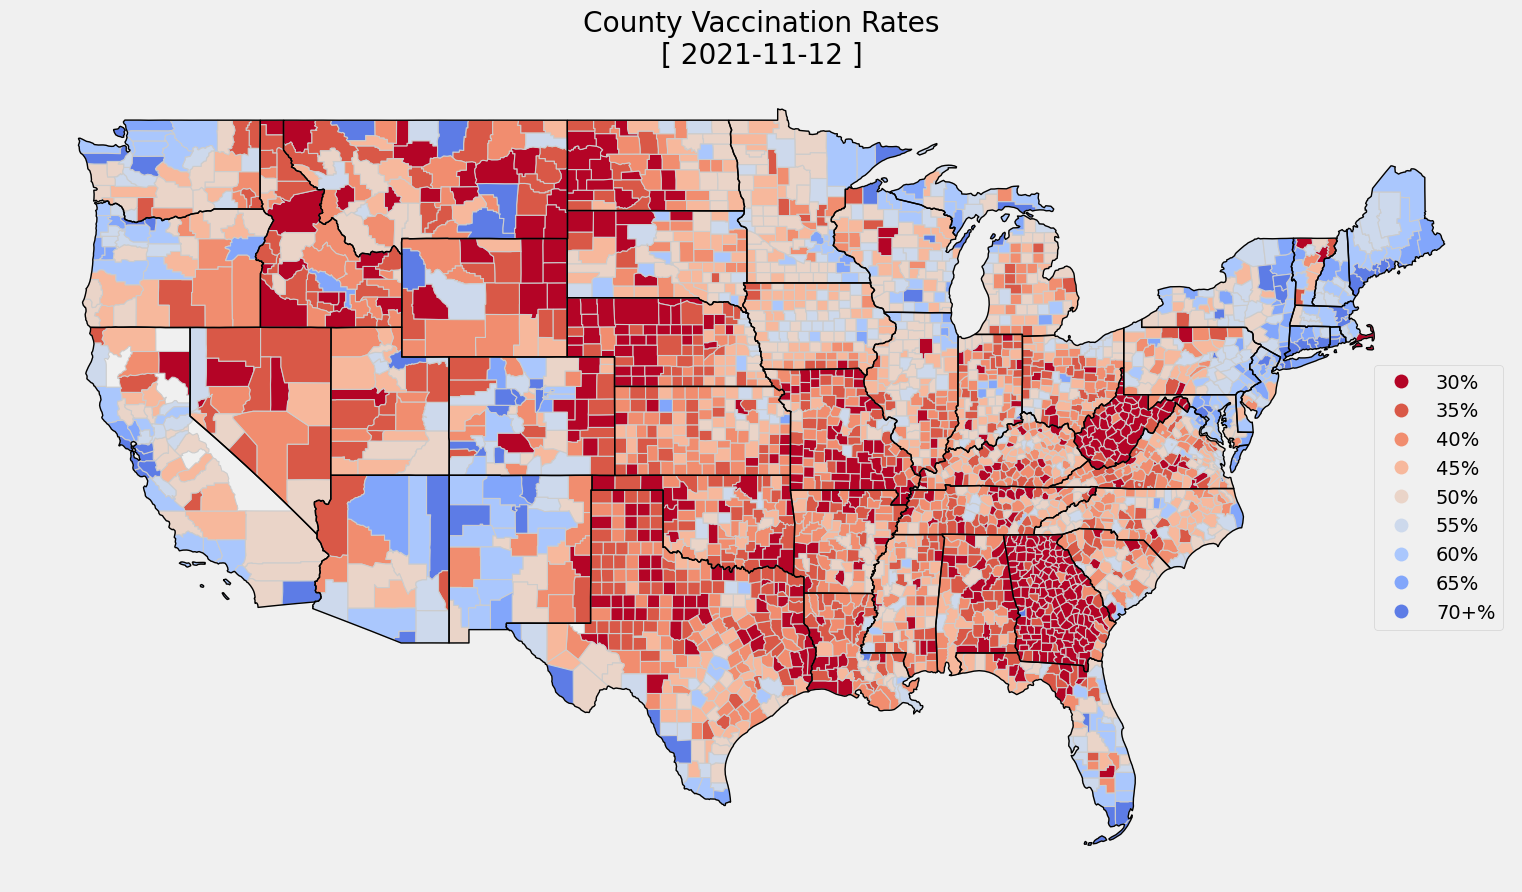

'C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/z_blog_natl_county_vax.jpg'

In [29]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


outfilename=f'z_blog_natl_county_vax.jpg'
              
#out_blog_images.append(outfilename)
fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")



#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"
copy_path = "wk09_10/"
shutil.copyfile(outfilename, f'{directory_path}{copy_path}{outfilename.split("/")[-1]}')



In [30]:
geo_county_tier_df

STATEFP  GEOID      NAME                                           geometry   FIPS      tier
0          37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  37017  total_40
1          37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  37167  total_35
2          39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...  39153  total_55
3          42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...  42113  total_45
4          48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...  48459  total_30
...       ...    ...       ...                                                ...    ...       ...
3094       22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...  22003  total_30
3095       38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  38005  total_45
3096       31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  31159  total_45
3097       37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  37023  total_40
3098       13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  13261  total_35

[3099 rows x 6 columns]

In [31]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 134


{'start_daily_100k_confirm': 0    10272
 1    10804
 2    10584
 3    10677
 4    10640
 5     9712
 6    10126
 7     9688
 8     9284
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9284,
 'start_daily_100k_confirm_max': 10804,
 'start_daily_mean_confirm': 0     3566.827789
 1     3487.485323
 2     4525.326810
 3     6835.035225
 4    12047.540117
 5    10439.352250
 6    14148.528376
 7     4375.837573
 8     5441.360078
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      6762.611940
 10     6997.925373
 11     9063.865672
 12    12205.932836
 13    18571.701493
 14    16568.328358
 15    16418.373134
 16     4357.888060
 17     5536.059701
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     68.387476
 1     67.438356
 2     85.819961
 3    120.909980
 4    197.966732
 5    160.906067
 6    271.782779
 7     80.958904
 8    108.311155
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     106.8

In [32]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10272
 1    10804
 2    10584
 3    10677
 4    10640
 5     9712
 6    10126
 7     9688
 8     9284
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9284,
 'start_daily_100k_confirm_max': 10804,
 'start_daily_mean_confirm': 0     3566.827789
 1     3487.485323
 2     4525.326810
 3     6835.035225
 4    12047.540117
 5    10439.352250
 6    14148.528376
 7     4375.837573
 8     5441.360078
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      6762.611940
 10     6997.925373
 11     9063.865672
 12    12205.932836
 13    18571.701493
 14    16568.328358
 15    16418.373134
 16     4357.888060
 17     5536.059701
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     68.387476
 1     67.438356
 2     85.819961
 3    120.909980
 4    197.966732
 5    160.906067
 6    271.782779
 7     80.958904
 8    108.311155
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     106.8

In [33]:
state_hosp_tiers_df

population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
5965    4157971 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5966    4157971 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5967    4157971 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5968    4157971 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5969    4157971 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3961   13485352 2021-11-08     32323     1600049      6654          6     5697.285714     42.247957        50.857143       0.377129  CT  [9, 23, 25, 44, 50]  total_70    30986.0   24880.0   
3962   13485352 2021-11-09     32374     1603338      9538         57     5949.571429      44.11877        49.857143       0.369713  CT  [9, 23, 25, 44, 50]  total_70    31207.0   25758.0   
3963   13485352 2021-11-10     32404     1607201      7152         81     6119.285714     45.377278        48.714286       0.361239  CT  [9, 23, 25, 44, 50]  total_70    33164.0   28045.0   
3964   13485352 2021-11-11     32410     1609107      5769         36     5978.714286     44.334877        43.571429       0.323102  CT  [9, 23, 25, 44, 50]  total_70    33317.0   28158.0   
3965   13485352 2021-11-12     32433     1614818      7617         29     6057.428571      44.91858        37.000000       0.274372  CT  [9, 23, 25, 44, 50]  total_70    33309.0   28097.0   

     covid_beds_used icu_total            icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
5965             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5966             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5967             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5968             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5969             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                 ...       ...              ...             ...              ...               ...  
3961          1066.0    2907.0   0.697954534180088     312.0           1048.0            18.0        42.247957          0.377129  
3962          1108.0    2922.0   0.729897601182115     308.0           1091.0            17.0         44.11877          0.369713  
3963          1154.0    2929.0   0.678133336756859     293.0           1139.0            15.0        45.377278          0.361239  
3964          1170.0    2922.0  0.6193588729361819     283.0           1159.0            11.0        44.334877          0.323102  
3965          1181.0    2923.0  0.6329297776557989     291.0           1165.0            16.0         44.91858          0.274372  

[4515 rows x 23 columns]

In [34]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  Administered_Dose1_Recip_12Plus  Administered_Dose1_Recip_12PlusPop_Pct  Administered_Dose1_Recip_18Plus  \
21714 2020-12-13       US                         0                         0.0                                0                                     0.0                                0   
21653 2020-12-14       US                         0                         0.0                                0                                     0.0                                0   
21628 2020-12-15       US                         0                         0.0                                0                                     0.0                                0   
21563 2020-12-16       US                         0                         0.0                                0                                     0.0                                0   
21475 2020-12-17       US                         0                         0.0                                0                                     0.0                                0   
...          ...      ...                       ...                         ...                              ...                                     ...                              ...   
295   2021-11-09       US                 224257467                        67.5                        223785718                                    78.9                        208689027   
212   2021-11-10       US                 224660453                        67.7                        224045726                                    79.0                        208928899   
153   2021-11-11       US                 225167371                        67.8                        224376879                                    79.1                        209240859   
122   2021-11-12       US                 225606197                        68.0                        224646990                                    79.2                        209488394   
49    2021-11-13       US                 226157226                        68.1                        224975987                                    79.4                        209794184   

       Administered_Dose1_Recip_18PlusPop_Pct  Administered_Dose1_Recip_65Plus  Administered_Dose1_Recip_65PlusPop_Pct  Series_Complete_Yes  Series_Complete_Pop_Pct  Series_Complete_12Plus  \
21714                                     0.0                                0                                     0.0                    0                      0.0                       0   
21653                                     0.0                                0                                     0.0                    0                      0.0                       0   
21628                                     0.0                                0                                     0.0                    0                      0.0                       0   
21563                                     0.0                                0                                     0.0                    0                      0.0                       0   
21475                                     0.0                                0                                     0.0                    0                      0.0                       0   
...                                       ...                              ...                                     ...                  ...                      ...                     ...   
295                                      80.8                         53897226                                    98.4            194168611                     58.5               194032115   
212                                      80.9                         53961229                                    98.5            194382921                     58.5               194246191   
153            

- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [35]:
#plt.get_cmap("Blues")
#//*** Assign Categories for color palettes
plot_cats = geo_county_tier_df['tier'].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


alt_colors = {}
counter = 0
for period in plot_cats:
    alt_colors[period] = colors_palette[counter]
    counter+=1
    
alt_colors


{'total_40': (0.705673158, 0.01555616, 0.150232812, 1.0),
 'total_35': (0.8523781350078431,
  0.34649194649411763,
  0.2803464686980392,
  1.0),
 'total_55': (0.9440545734235294, 0.5531534787490197, 0.4355484903137255, 1.0),
 'total_45': (0.968203399, 0.7208441, 0.6122929913333334, 1.0),
 'total_30': (0.9193759889058823, 0.8312727235294118, 0.7828736304470588, 1.0),
 'total_50': (0.8049647588235295, 0.8516661605568627, 0.9261650744313725, 1.0),
 'total_70': (0.6672529243333334, 0.7791764569999999, 0.992959213, 1.0),
 'total_60': (0.5108243242509803, 0.6493966148235294, 0.9850787763764707, 1.0),
 'total_65': (0.3634607953411765, 0.4847836818509804, 0.9010188868941177, 1.0)}

In [36]:
#tier.replace("total_","")+"%"
colors
if 'geometry' not in geo_county_vax_tier_df.columns:
    print("Merge Geo Data with vax")


    geo_county_vax_tier_df = geo_county_tier_df[["STATEFP","GEOID","geometry"]].merge(geo_county_vax_tier_df,left_on='GEOID',right_on='FIPS')

Merge Geo Data with vax


In [37]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        death_filename = f"{filepath}death_hist_{file_counter}.jpg"
        vax_filename = f"{filepath}vax_hist_{file_counter}.jpg"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                out_controls['copy_files']['infographic_cases'].append(death_filename)
                out_controls['copy_files']['infographic_cases'].append(vax_filename)
                
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,4)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(death_filename)
        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 90})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(vax_filename)
        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()



    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/confirm_hist_645.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/death_hist_645.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/vax_hist_645.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/confirm_hist_646.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/death_hist_646.jpg
C:/Users/family/DSCProjects/DSC/DSC640/project/infographic_confirm/vax_hist_646.jpg
Done...
Done!


In [38]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"

"""
for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")
"""

for key,action in out_controls.items():
    
    
    if key == 'copy_files':
        
        for action_key,action_values in action.items():
            if action_key == "infographic_cases":
                copy_path = "wk09_10/infographic_gifs/"
                
                for filename in action_values:
                    try:
                        print(f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                        shutil.copyfile(filename, f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                    except:
                        continue
                

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_1.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_2.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_3.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_4.jp

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_69.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_70.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_70.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_70.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_71.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_71.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_71.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_72.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_72.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_144.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_144.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_144.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_145.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_145.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_145.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_146.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_146.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_146.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_204.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_204.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_204.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_205.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_205.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_205.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_206.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_206.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_206.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_275.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_275.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_276.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_276.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_276.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_277.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_277.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_277.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_278.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_340.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_340.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_340.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_341.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_341.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_341.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_342.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_342.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_342.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_396.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_396.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_396.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_397.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_397.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_397.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_398.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_398.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_398.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_454.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_454.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_454.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_455.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_455.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_455.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_456.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_456.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_456.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_510.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_511.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_511.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_511.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_512.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_512.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_512.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_513.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_513.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_559.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_560.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_560.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_560.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_561.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_561.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_561.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_562.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_562.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_618.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_618.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_618.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_619.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_619.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_619.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_620.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_620.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_620.jpg
C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs

In [39]:
all_dates

['1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/20',
 '4/17/20',
 '4/18/20',
 '4/19/20',
 '4/20/20',
 '4/21/20',
 '4/22/20',
 '4/23/

Working...


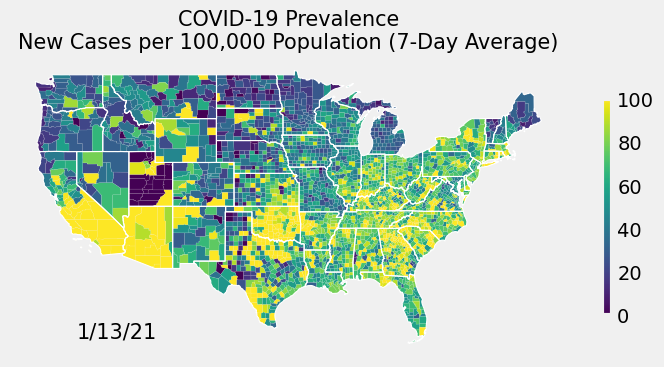

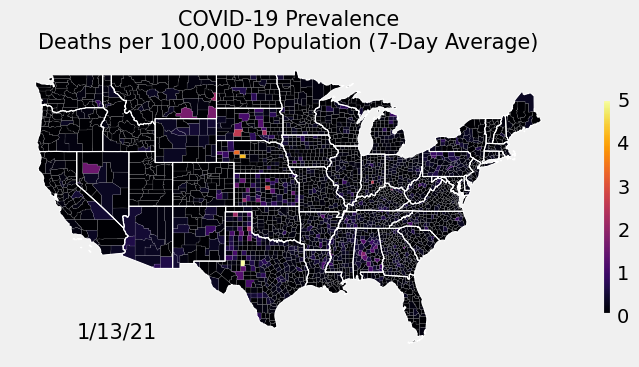

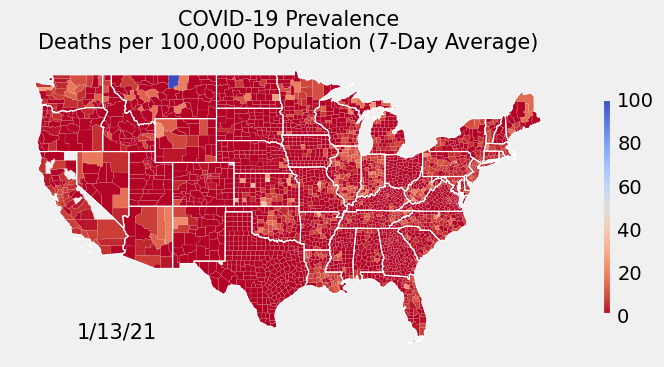

Done...
Done!


In [40]:
#2021/01/13


("1/13/21" in all_dates)



#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in ["1/13/21"]:
        

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.savefig("test.jpg",pil_kwargs={'quality': 95})
        plt.show()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()
     #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()



    print("Done...")
plt.rcdefaults()

print("Done!")

In [41]:
"""
linewidth=.2
counter = 0
for tier in geo_county_tier_df['tier'].unique():
    counter += 1
    temp_plot = geo_county_tier_df[geo_county_tier_df['tier'] == tier]

    if counter > 3:
        linewidth+=.2


    ax = temp_plot.plot(categorical=True,legend=True, linewidth=linewidth,edgecolor=alt_colors[tier],color=(1,1,1,0),ax=ax)

#geo_county_tier_df

temp_plot = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]

if len(temp_plot) > 0:
    #ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, linewidth=linewidth,cmap=plt.get_cmap("viridis"),color=(1,1,1,0),ax=ax)
    ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, marker='.', linewidth=linewidth,cmap=plt.get_cmap("Blues"),markersize=1,ax=ax)
"""

geo_county_vax_tier_df
print(attrib_death_df)

     STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Deaths  1/29/20_New_Deaths_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   0                            0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                   0                            0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                   0                            0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   0                            0   
4         48  48459    Up

In [42]:
attrib_confirm_df['1/5/21_scaled_100k'].max()

100

In [43]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
#out_plot['confirm_historical'] = out_html

In [44]:
county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263      991595      16736       15829        104    22148.285714   
335  2020-12-22  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263     1005007      16943       20245        252    22258.428571   
336  2020-12-23  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263     1017349      17132       25754        396    22417.142857   
337  2020-12-24  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263     1031456      17301       26449        358    22595.714286   
338  2020-12-25  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263     1039236      17396       21887        264    21879.857143   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
656  2021-11-08  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3504430      58610       10177         56     8179.714286   
657  2021-11-09  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3507886      58647       10600         87     8302.285714   
658  2021-11-10  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3512973      58701        8543         91     8494.142857   
659  2021-11-11  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3516023      58706        8137         59     8417.571429   
660  2021-11-12  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3523197      58743       10224         42     8403.857143   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       266.571429    124.826452       1.502381              100          1.502381                      0.0                      0            0.0              0.0  total_30  
335       267.142857    125.447211       1.505602              100          1.505602                      0.0                      0            0.0              0.0  total_30  
336       273.285714    126.341715       1.540222              100          1.540222                      0.0                      0            0.0              0.0  total_30  
337       273.000000    127.348134       1.538612              100          1.538612                      0.0                      0            0.0              0.0  total_30  
338       267.428571    123.313604       1.507212              100          1.507212                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
656        76.428571     27.311646       0.255191        27.311646          0.255191                73.466874               22002996      82.455988       24695195.0  total_70  
657        76.428571     27.720906       0.255191        27.720906          0.255191                 73.50588               22014678      82.551232       24723720.0  total_70  
658        76.428571     28.361507       0.255191        28.361507          0.255191                73.564301               22032175      82.707765       24770601.0  total_7

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [45]:
geo_county_vax_tier_df['Date'].iloc[1]

datetime.date(2021, 11, 13)

In [46]:
import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()
    
out_master = {}

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily","total_vaccinated_percent"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in whole_county_tier_df['Date'].unique():
    #if date >= start_summer_date:
    #    break
    loop_df = whole_county_tier_df[whole_county_tier_df['Date'] == date].copy()
    loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date].copy()
    
   
    
    
    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_confirm)
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                
                case_100k_avg_daily = round(tot_confirm / (pop / 100000),4)
                case_100k_avg_daily = round(case_100k_avg_daily / days,4)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue
                
            if col == "total_vaccinated_percent":
                #//**** No Vaccaination Data Yet
                #loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date]
                #total_vaccinated_percent = "0%"
                #td[col].append("0%")
                if len(loop_vax_df) == 0:
                    total_vaccinated_percent = "0.0%"
                    td[col].append("0%")
                else:
                    #print(geo_county_vax_tier_df)
                    
                    total_vaccinated_percent = loop_vax_df[loop_vax_df['tier'] == tier][col].values[0]
                    total_vaccinated_percent = str(total_vaccinated_percent) + "%"
                    td[col].append(total_vaccinated_percent)
                continue

    #print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm,total_vaccinated_percent)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['New_Confirm'][x],td['tier'][x],td['case_100k_avg'][x],td["relative_confirm_100k"][x],td['total_vaccinated_percent'][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_left'] = {
    'filename' : 'infographic_left.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_left = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
last_date = td['Date'][-1]
print("Done!")

0 2020/02/06 total_30 0 total_30 0.0 0% 0%
1 2020/02/06 total_35 0 total_35 0.0 0% 0%
2 2020/02/06 total_40 0 total_40 0.0 0% 0%
3 2020/02/06 total_45 0 total_45 0.0 0% 0%
4 2020/02/06 total_50 0 total_50 0.0 0% 0%
5 2020/02/06 total_55 0 total_55 0.0 0% 0%
6 2020/02/06 total_60 1 total_60 0.0014 0% 0%
7 2020/02/06 total_65 0 total_65 0.0 0% 0%
8 2020/02/06 total_70 0 total_70 0.0 0% 0%
9 2020/02/07 total_30 0 total_30 0.0 0% 0%
10 2020/02/07 total_35 0 total_35 0.0 0% 0%
11 2020/02/07 total_40 0 total_40 0.0 0% 0%
12 2020/02/07 total_45 0 total_45 0.0 0% 0%
13 2020/02/07 total_50 0 total_50 0.0 0% 0%
14 2020/02/07 total_55 0 total_55 0.0 0% 0%
15 2020/02/07 total_60 1 total_60 0.0014 0% 0%
16 2020/02/07 total_65 0 total_65 0.0 0% 0%
17 2020/02/07 total_70 0 total_70 0.0 0% 0%
18 2020/02/08 total_30 0 total_30 0.0 0% 0%
19 2020/02/08 total_35 0 total_35 0.0 0% 0%
20 2020/02/08 total_40 0 total_40 0.0 0% 0%
21 2020/02/08 total_45 0 total_45 0.0 0% 0%
22 2020/02/08 total_50 0 total_50 0.

265 2020/03/06 total_50 7 total_50 0.0121 216.07% 0%
266 2020/03/06 total_55 11 total_55 0.02 357.14% 0%
267 2020/03/06 total_60 26 total_60 0.0364 650.0% 0%
268 2020/03/06 total_65 14 total_65 0.0607 1083.93% 0%
269 2020/03/06 total_70 74 total_70 0.2471 4412.5% 0%
270 2020/03/07 total_30 2 total_30 0.0113 100.0% 0%
271 2020/03/07 total_35 1 total_35 0.0061 53.98% 0%
272 2020/03/07 total_40 0 total_40 0.0 0.0% 0%
273 2020/03/07 total_45 4 total_45 0.0122 107.96% 0%
274 2020/03/07 total_50 12 total_50 0.0207 183.19% 0%
275 2020/03/07 total_55 20 total_55 0.0364 322.12% 0%
276 2020/03/07 total_60 29 total_60 0.0406 359.29% 0%
277 2020/03/07 total_65 21 total_65 0.091 805.31% 0%
278 2020/03/07 total_70 143 total_70 0.4775 4225.66% 0%
279 2020/03/08 total_30 1 total_30 0.0056 100.0% 0%
280 2020/03/08 total_35 2 total_35 0.0121 216.07% 0%
281 2020/03/08 total_40 0 total_40 0.0 0.0% 0%
282 2020/03/08 total_45 7 total_45 0.0214 382.14% 0%
283 2020/03/08 total_50 14 total_50 0.0242 432.14% 0%

527 2020/04/04 total_55 8334 total_55 15.1736 170.08% 0%
528 2020/04/04 total_60 19997 total_60 28.0089 313.94% 0%
529 2020/04/04 total_65 9368 total_65 40.5916 454.98% 0%
530 2020/04/04 total_70 14038 total_70 46.8722 525.37% 0%
531 2020/04/05 total_30 1340 total_30 7.5522 100.0% 0%
532 2020/04/05 total_35 951 total_35 5.7657 76.34% 0%
533 2020/04/05 total_40 1748 total_40 8.0007 105.94% 0%
534 2020/04/05 total_45 3670 total_45 11.2198 148.56% 0%
535 2020/04/05 total_50 4744 total_50 8.1998 108.57% 0%
536 2020/04/05 total_55 7719 total_55 14.0539 186.09% 0%
537 2020/04/05 total_60 20646 total_60 28.9179 382.91% 0%
538 2020/04/05 total_65 8917 total_65 38.6374 511.6% 0%
539 2020/04/05 total_70 12786 total_70 42.6918 565.29% 0%
540 2020/04/06 total_30 1350 total_30 7.6085 100.0% 0%
541 2020/04/06 total_35 853 total_35 5.1715 67.97% 0%
542 2020/04/06 total_40 1455 total_40 6.6596 87.53% 0%
543 2020/04/06 total_45 3626 total_45 11.0853 145.7% 0%
544 2020/04/06 total_50 4398 total_50 7.601

827 2020/05/07 total_70 5571 total_70 18.6013 176.31% 0%
828 2020/05/08 total_30 1690 total_30 9.5247 100.0% 0%
829 2020/05/08 total_35 1772 total_35 10.7432 112.79% 0%
830 2020/05/08 total_40 2085 total_40 9.5432 100.19% 0%
831 2020/05/08 total_45 3424 total_45 10.4678 109.9% 0%
832 2020/05/08 total_50 6600 total_50 11.4078 119.77% 0%
833 2020/05/08 total_55 8069 total_55 14.6911 154.24% 0%
834 2020/05/08 total_60 16898 total_60 23.6682 248.49% 0%
835 2020/05/08 total_65 7415 total_65 32.1293 337.33% 0%
836 2020/05/08 total_70 6254 total_70 20.8818 219.24% 0%
837 2020/05/09 total_30 1550 total_30 8.7357 100.0% 0%
838 2020/05/09 total_35 1731 total_35 10.4946 120.13% 0%
839 2020/05/09 total_40 2518 total_40 11.525 131.93% 0%
840 2020/05/09 total_45 3384 total_45 10.3455 118.43% 0%
841 2020/05/09 total_50 6907 total_50 11.9385 136.66% 0%
842 2020/05/09 total_55 8162 total_55 14.8605 170.11% 0%
843 2020/05/09 total_60 15477 total_60 21.6779 248.15% 0%
844 2020/05/09 total_65 6067 total_6

1139 2020/06/11 total_55 7100 total_55 12.9269 98.02% 0%
1140 2020/06/11 total_60 10926 total_60 15.3035 116.04% 0%
1141 2020/06/11 total_65 2289 total_65 9.9183 75.21% 0%
1142 2020/06/11 total_70 3208 total_70 10.7113 81.22% 0%
1143 2020/06/12 total_30 2687 total_30 15.1438 100.0% 0%
1144 2020/06/12 total_35 2577 total_35 15.6237 103.17% 0%
1145 2020/06/12 total_40 2653 total_40 12.1429 80.18% 0%
1146 2020/06/12 total_45 4960 total_45 15.1636 100.13% 0%
1147 2020/06/12 total_50 8958 total_50 15.4835 102.24% 0%
1148 2020/06/12 total_55 7989 total_55 14.5455 96.05% 0%
1149 2020/06/12 total_60 11966 total_60 16.7602 110.67% 0%
1150 2020/06/12 total_65 2328 total_65 10.0872 66.61% 0%
1151 2020/06/12 total_70 3041 total_70 10.1537 67.05% 0%
1152 2020/06/13 total_30 2949 total_30 16.6204 100.0% 0%
1153 2020/06/13 total_35 2843 total_35 17.2364 103.71% 0%
1154 2020/06/13 total_40 2945 total_40 13.4794 81.1% 0%
1155 2020/06/13 total_45 5130 total_45 15.6833 94.36% 0%
1156 2020/06/13 total_50 

1452 2020/07/16 total_45 14770 total_45 45.1545 88.67% 0%
1453 2020/07/16 total_50 29397 total_50 50.8115 99.77% 0%
1454 2020/07/16 total_55 22013 total_55 40.0788 78.7% 0%
1455 2020/07/16 total_60 35891 total_60 50.2708 98.71% 0%
1456 2020/07/16 total_65 4709 total_65 20.4041 40.07% 0%
1457 2020/07/16 total_70 10147 total_70 33.8803 66.53% 0%
1458 2020/07/17 total_30 9036 total_30 50.9264 100.0% 0%
1459 2020/07/17 total_35 7589 total_35 46.0101 90.35% 0%
1460 2020/07/17 total_40 9398 total_40 43.0152 84.47% 0%
1461 2020/07/17 total_45 14251 total_45 43.5678 85.55% 0%
1462 2020/07/17 total_50 30939 total_50 53.4768 105.01% 0%
1463 2020/07/17 total_55 23330 total_55 42.4767 83.41% 0%
1464 2020/07/17 total_60 36558 total_60 51.2051 100.55% 0%
1465 2020/07/17 total_65 4486 total_65 19.4379 38.17% 0%
1466 2020/07/17 total_70 10113 total_70 33.7668 66.31% 0%
1467 2020/07/18 total_30 9199 total_30 51.845 100.0% 0%
1468 2020/07/18 total_35 6973 total_35 42.2755 81.54% 0%
1469 2020/07/18 total

1764 2020/08/20 total_30 7697 total_30 43.3798 100.0% 0%
1765 2020/08/20 total_35 6601 total_35 40.0202 92.26% 0%
1766 2020/08/20 total_40 7331 total_40 33.5544 77.35% 0%
1767 2020/08/20 total_45 10527 total_45 32.1829 74.19% 0%
1768 2020/08/20 total_50 15376 total_50 26.5768 61.27% 0%
1769 2020/08/20 total_55 13877 total_55 25.2657 58.24% 0%
1770 2020/08/20 total_60 16656 total_60 23.3293 53.78% 0%
1771 2020/08/20 total_65 4058 total_65 17.5833 40.53% 0%
1772 2020/08/20 total_70 6317 total_70 21.0921 48.62% 0%
1773 2020/08/21 total_30 8305 total_30 46.8065 100.0% 0%
1774 2020/08/21 total_35 6916 total_35 41.9299 89.58% 0%
1775 2020/08/21 total_40 7432 total_40 34.0167 72.68% 0%
1776 2020/08/21 total_45 11090 total_45 33.9041 72.43% 0%
1777 2020/08/21 total_50 16783 total_50 29.0087 61.98% 0%
1778 2020/08/21 total_55 14396 total_55 26.2106 56.0% 0%
1779 2020/08/21 total_60 16204 total_60 22.6962 48.49% 0%
1780 2020/08/21 total_65 4072 total_65 17.644 37.7% 0%
1781 2020/08/21 total_70 6

2077 2020/09/23 total_65 3323 total_65 14.3986 41.28% 0%
2078 2020/09/23 total_70 4243 total_70 14.1672 40.62% 0%
2079 2020/09/24 total_30 6990 total_30 39.3952 100.0% 0%
2080 2020/09/24 total_35 7414 total_35 44.9492 114.1% 0%
2081 2020/09/24 total_40 8550 total_40 39.1338 99.34% 0%
2082 2020/09/24 total_45 11335 total_45 34.6531 87.96% 0%
2083 2020/09/24 total_50 15476 total_50 26.7496 67.9% 0%
2084 2020/09/24 total_55 14841 total_55 27.0208 68.59% 0%
2085 2020/09/24 total_60 11481 total_60 16.0809 40.82% 0%
2086 2020/09/24 total_65 4106 total_65 17.7913 45.16% 0%
2087 2020/09/24 total_70 4665 total_70 15.5762 39.54% 0%
2088 2020/09/25 total_30 7291 total_30 41.0917 100.0% 0%
2089 2020/09/25 total_35 7751 total_35 46.9923 114.36% 0%
2090 2020/09/25 total_40 8921 total_40 40.8319 99.37% 0%
2091 2020/09/25 total_45 12397 total_45 37.8998 92.23% 0%
2092 2020/09/25 total_50 15903 total_50 27.4877 66.89% 0%
2093 2020/09/25 total_55 16732 total_55 30.4638 74.14% 0%
2094 2020/09/25 total_60

2389 2020/10/28 total_50 27774 total_50 48.0063 108.7% 0%
2390 2020/10/28 total_55 27191 total_55 49.5063 112.1% 0%
2391 2020/10/28 total_60 27751 total_60 38.8695 88.01% 0%
2392 2020/10/28 total_65 11296 total_65 48.9457 110.83% 0%
2393 2020/10/28 total_70 8351 total_70 27.8836 63.14% 0%
2394 2020/10/29 total_30 7937 total_30 44.7325 100.0% 0%
2395 2020/10/29 total_35 10939 total_35 66.3203 148.26% 0%
2396 2020/10/29 total_40 15228 total_40 69.6994 155.81% 0%
2397 2020/10/29 total_45 21138 total_45 64.6226 144.46% 0%
2398 2020/10/29 total_50 30638 total_50 52.9566 118.39% 0%
2399 2020/10/29 total_55 28452 total_55 51.8022 115.8% 0%
2400 2020/10/29 total_60 31065 total_60 43.5113 97.27% 0%
2401 2020/10/29 total_65 12433 total_65 53.8723 120.43% 0%
2402 2020/10/29 total_70 9284 total_70 30.9988 69.3% 0%
2403 2020/10/30 total_30 8871 total_30 49.9964 100.0% 0%
2404 2020/10/30 total_35 12523 total_35 75.9237 151.86% 0%
2405 2020/10/30 total_40 16491 total_40 75.4802 150.97% 0%
2406 2020/1

2702 2020/12/02 total_40 31139 total_40 142.525 124.98% 0%
2703 2020/12/02 total_45 43382 total_45 132.6265 116.3% 0%
2704 2020/12/02 total_50 79910 total_50 138.1213 121.12% 0%
2705 2020/12/02 total_55 61033 total_55 111.1221 97.44% 0%
2706 2020/12/02 total_60 79707 total_60 111.6418 97.9% 0%
2707 2020/12/02 total_65 25666 total_65 111.211 97.52% 0%
2708 2020/12/02 total_70 26254 total_70 87.6608 76.87% 0%
2709 2020/12/03 total_30 21923 total_30 123.5568 100.0% 0%
2710 2020/12/03 total_35 24986 total_35 151.4837 122.6% 0%
2711 2020/12/03 total_40 34280 total_40 156.9015 126.99% 0%
2712 2020/12/03 total_45 45737 total_45 139.8261 113.17% 0%
2713 2020/12/03 total_50 81449 total_50 140.7814 113.94% 0%
2714 2020/12/03 total_55 66230 total_55 120.5842 97.59% 0%
2715 2020/12/03 total_60 86086 total_60 120.5766 97.59% 0%
2716 2020/12/03 total_65 30126 total_65 130.5362 105.65% 0%
2717 2020/12/03 total_70 30686 total_70 102.459 82.92% 0%
2718 2020/12/04 total_30 22833 total_30 128.6855 100.0%

3014 2021/01/05 total_70 31954 total_70 106.6928 85.01% 0.0%
3015 2021/01/06 total_30 28657 total_30 161.5092 100.0% 0.0%
3016 2021/01/06 total_35 26550 total_35 160.9658 99.66% 0.0%
3017 2021/01/06 total_40 37311 total_40 170.7745 105.74% 0.0%
3018 2021/01/06 total_45 52941 total_45 161.8501 100.21% 0.0%
3019 2021/01/06 total_50 91469 total_50 158.1005 97.89% 0.0%
3020 2021/01/06 total_55 67839 total_55 123.5137 76.47% 0.0%
3021 2021/01/06 total_60 109110 total_60 152.8252 94.62% 0.0%
3022 2021/01/06 total_65 29111 total_65 126.1382 78.1% 0.0%
3023 2021/01/06 total_70 38071 total_70 127.1171 78.71% 0.0%
3024 2021/01/07 total_30 28829 total_30 162.4786 100.0% 0.0%
3025 2021/01/07 total_35 28222 total_35 171.1027 105.31% 0.0%
3026 2021/01/07 total_40 39335 total_40 180.0385 110.81% 0.0%
3027 2021/01/07 total_45 55719 total_45 170.3429 104.84% 0.0%
3028 2021/01/07 total_50 105930 total_50 183.0958 112.69% 0.0%
3029 2021/01/07 total_55 78375 total_55 142.6965 87.82% 0.0%
3030 2021/01/07 t

3326 2021/02/09 total_55 25996 total_55 47.3306 83.5% 2.0%
3327 2021/02/09 total_60 40934 total_60 57.3343 101.15% 2.1%
3328 2021/02/09 total_65 11772 total_65 51.0082 89.99% 3.7%
3329 2021/02/09 total_70 19104 total_70 63.7873 112.54% 0.0%
3330 2021/02/10 total_30 11730 total_30 66.1096 100.0% 0.0%
3331 2021/02/10 total_35 10585 total_35 64.1741 97.07% 2.0%
3332 2021/02/10 total_40 13477 total_40 61.685 93.31% 4.7%
3333 2021/02/10 total_45 20335 total_45 62.1677 94.04% 3.1%
3334 2021/02/10 total_50 32936 total_50 56.9286 86.11% 3.8%
3335 2021/02/10 total_55 27967 total_55 50.9192 77.02% 2.1%
3336 2021/02/10 total_60 43363 total_60 60.7365 91.87% 2.2%
3337 2021/02/10 total_65 11865 total_65 51.4111 77.77% 4.2%
3338 2021/02/10 total_70 17230 total_70 57.5301 87.02% 0.0%
3339 2021/02/11 total_30 11595 total_30 65.3487 100.0% 0.0%
3340 2021/02/11 total_35 11543 total_35 69.9822 107.09% 2.1%
3341 2021/02/11 total_40 15363 total_40 70.3173 107.6% 5.5%
3342 2021/02/11 total_45 22580 total_45

3639 2021/03/16 total_45 11603 total_45 35.4724 127.46% 13.8%
3640 2021/03/16 total_50 15292 total_50 26.4316 94.97% 13.0%
3641 2021/03/16 total_55 17442 total_55 31.7564 114.11% 8.6%
3642 2021/03/16 total_60 24282 total_60 34.0107 122.21% 8.7%
3643 2021/03/16 total_65 8255 total_65 35.769 128.53% 19.2%
3644 2021/03/16 total_70 13140 total_70 43.8738 157.65% 5.0%
3645 2021/03/17 total_30 5320 total_30 29.9832 100.0% 0.0%
3646 2021/03/17 total_35 4465 total_35 27.0701 90.28% 8.6%
3647 2021/03/17 total_40 6090 total_40 27.8743 92.97% 12.8%
3648 2021/03/17 total_45 12025 total_45 36.7626 122.61% 14.9%
3649 2021/03/17 total_50 16092 total_50 27.8144 92.77% 14.1%
3650 2021/03/17 total_55 19817 total_55 36.0806 120.34% 8.7%
3651 2021/03/17 total_60 27163 total_60 38.0459 126.89% 8.9%
3652 2021/03/17 total_65 9114 total_65 39.491 131.71% 19.6%
3653 2021/03/17 total_70 13132 total_70 43.8471 146.24% 6.8%
3654 2021/03/18 total_30 5751 total_30 32.4123 100.0% 0.0%
3655 2021/03/18 total_35 4864 t

3951 2021/04/20 total_30 3624 total_30 20.4247 100.0% 0.0%
3952 2021/04/20 total_35 4223 total_35 25.603 125.35% 12.0%
3953 2021/04/20 total_40 6926 total_40 31.7007 155.21% 18.3%
3954 2021/04/20 total_45 15927 total_45 48.6917 238.4% 23.4%
3955 2021/04/20 total_50 20827 total_50 35.9986 176.25% 31.1%
3956 2021/04/20 total_55 22647 total_55 41.2331 201.88% 21.9%
3957 2021/04/20 total_60 28344 total_60 39.7001 194.37% 21.8%
3958 2021/04/20 total_65 8949 total_65 38.7761 189.85% 36.6%
3959 2021/04/20 total_70 11364 total_70 37.9438 185.77% 26.6%
3960 2021/04/21 total_30 4571 total_30 25.7619 100.0% 0.0%
3961 2021/04/21 total_35 4774 total_35 28.9435 112.35% 12.1%
3962 2021/04/21 total_40 7149 total_40 32.7214 127.01% 18.4%
3963 2021/04/21 total_45 14175 total_45 43.3355 168.22% 23.7%
3964 2021/04/21 total_50 20607 total_50 35.6184 138.26% 31.3%
3965 2021/04/21 total_55 22998 total_55 41.8722 162.54% 23.0%
3966 2021/04/21 total_60 29511 total_60 41.3347 160.45% 22.1%
3967 2021/04/21 total

4264 2021/05/24 total_65 2210 total_65 9.5759 104.88% 48.3%
4265 2021/05/24 total_70 3352 total_70 11.1922 122.58% 54.2%
4266 2021/05/25 total_30 2505 total_30 14.118 100.0% 0.0%
4267 2021/05/25 total_35 2536 total_35 15.3751 108.9% 15.4%
4268 2021/05/25 total_40 3359 total_40 15.3743 108.9% 22.2%
4269 2021/05/25 total_45 6408 total_45 19.5904 138.76% 32.8%
4270 2021/05/25 total_50 8296 total_50 14.3393 101.57% 41.1%
4271 2021/05/25 total_55 9548 total_55 17.3839 123.13% 34.5%
4272 2021/05/25 total_60 9236 total_60 12.9364 91.63% 33.4%
4273 2021/05/25 total_65 2413 total_65 10.4556 74.06% 48.4%
4274 2021/05/25 total_70 3253 total_70 10.8616 76.93% 54.2%
4275 2021/05/26 total_30 2581 total_30 14.5464 100.0% 0.0%
4276 2021/05/26 total_35 2607 total_35 15.8056 108.66% 15.4%
4277 2021/05/26 total_40 3760 total_40 17.2097 118.31% 22.2%
4278 2021/05/26 total_45 5402 total_45 16.5149 113.53% 33.1%
4279 2021/05/26 total_50 8794 total_50 15.2001 104.49% 41.3%
4280 2021/05/26 total_55 9822 total

4576 2021/06/28 total_50 4472 total_50 7.7297 244.47% 44.5%
4577 2021/06/28 total_55 2374 total_55 4.3223 136.7% 39.8%
4578 2021/06/28 total_60 2936 total_60 4.1123 130.06% 41.5%
4579 2021/06/28 total_65 891 total_65 3.8607 122.1% 55.4%
4580 2021/06/28 total_70 998 total_70 3.3323 105.39% 61.2%
4581 2021/06/29 total_30 1580 total_30 8.9048 100.0% 0.0%
4582 2021/06/29 total_35 2090 total_35 12.6711 142.3% 17.3%
4583 2021/06/29 total_40 2874 total_40 13.1545 147.72% 24.4%
4584 2021/06/29 total_45 3306 total_45 10.107 113.5% 38.1%
4585 2021/06/29 total_50 5170 total_50 8.9361 100.35% 44.6%
4586 2021/06/29 total_55 2655 total_55 4.8339 54.28% 39.8%
4587 2021/06/29 total_60 3369 total_60 4.7188 52.99% 41.6%
4588 2021/06/29 total_65 772 total_65 3.3451 37.57% 55.4%
4589 2021/06/29 total_70 0 total_70 0.0 0.0% 61.3%
4590 2021/06/30 total_30 2381 total_30 13.4192 100.0% 0.0%
4591 2021/06/30 total_35 2688 total_35 16.2966 121.44% 17.3%
4592 2021/06/30 total_40 3128 total_40 14.317 106.69% 24.4%

4889 2021/08/02 total_40 14525 total_40 66.4817 138.32% 25.8%
4890 2021/08/02 total_45 18603 total_45 56.8727 118.33% 39.8%
4891 2021/08/02 total_50 35926 total_50 62.0967 129.2% 45.5%
4892 2021/08/02 total_55 23333 total_55 42.4821 88.39% 41.6%
4893 2021/08/02 total_60 25571 total_60 35.8161 74.52% 46.0%
4894 2021/08/02 total_65 5846 total_65 25.3308 52.7% 58.1%
4895 2021/08/02 total_70 11722 total_70 39.1392 81.43% 63.3%
4896 2021/08/03 total_30 18177 total_30 102.4445 100.0% 0.0%
4897 2021/08/03 total_35 15100 total_35 91.5474 89.36% 18.5%
4898 2021/08/03 total_40 22713 total_40 103.9587 101.48% 25.8%
4899 2021/08/03 total_45 27528 total_45 84.158 82.15% 39.9%
4900 2021/08/03 total_50 41648 total_50 71.9869 70.27% 45.6%
4901 2021/08/03 total_55 28802 total_55 52.4395 51.19% 41.7%
4902 2021/08/03 total_60 37443 total_60 52.4446 51.19% 46.0%
4903 2021/08/03 total_65 8167 total_65 35.3877 34.54% 58.1%
4904 2021/08/03 total_70 10198 total_70 34.0506 33.24% 63.7%
4905 2021/08/04 total_30

5201 2021/09/05 total_70 6202 total_70 20.7082 48.85% 65.6%
5202 2021/09/06 total_30 6556 total_30 36.9492 100.0% 0.0%
5203 2021/09/06 total_35 10445 total_35 63.3253 171.38% 20.7%
5204 2021/09/06 total_40 13067 total_40 59.8084 161.87% 28.7%
5205 2021/09/06 total_45 15248 total_45 46.6158 126.16% 41.7%
5206 2021/09/06 total_50 22386 total_50 38.6933 104.72% 47.8%
5207 2021/09/06 total_55 16392 total_55 29.8447 80.77% 43.8%
5208 2021/09/06 total_60 16644 total_60 23.3125 63.09% 51.3%
5209 2021/09/06 total_65 5607 total_65 24.2952 65.75% 61.2%
5210 2021/09/06 total_70 6557 total_70 21.8935 59.25% 65.6%
5211 2021/09/07 total_30 32996 total_30 185.9635 100.0% 0.0%
5212 2021/09/07 total_35 30399 total_35 184.3013 99.11% 20.7%
5213 2021/09/07 total_40 34794 total_40 159.2541 85.64% 28.8%
5214 2021/09/07 total_45 49793 total_45 152.2261 81.86% 41.8%
5215 2021/09/07 total_50 55726 total_50 96.3202 51.8% 48.2%
5216 2021/09/07 total_55 45895 total_55 83.5605 44.93% 43.9%
5217 2021/09/07 total_6

5513 2021/10/10 total_55 11950 total_55 21.7572 114.52% 55.5%
5514 2021/10/10 total_60 10285 total_60 14.4057 75.82% 57.2%
5515 2021/10/10 total_65 4464 total_65 19.3426 101.81% 64.4%
5516 2021/10/10 total_70 3976 total_70 13.2757 69.88% 67.8%
5517 2021/10/11 total_30 4097 total_30 23.0905 100.0% 0.0%
5518 2021/10/11 total_35 7837 total_35 47.5137 205.77% 23.5%
5519 2021/10/11 total_40 10526 total_40 48.1781 208.65% 32.3%
5520 2021/10/11 total_45 19444 total_45 59.4438 257.44% 44.1%
5521 2021/10/11 total_50 32094 total_50 55.4732 240.24% 50.1%
5522 2021/10/11 total_55 23897 total_55 43.509 188.43% 55.6%
5523 2021/10/11 total_60 20235 total_60 28.3422 122.74% 57.2%
5524 2021/10/11 total_65 7209 total_65 31.2367 135.28% 64.4%
5525 2021/10/11 total_70 8118 total_70 27.1056 117.39% 67.8%
5526 2021/10/12 total_30 11958 total_30 67.3946 100.0% 0.0%
5527 2021/10/12 total_35 13215 total_35 80.1191 118.88% 23.7%
5528 2021/10/12 total_40 17645 total_40 80.7622 119.83% 32.3%
5529 2021/10/12 total

Done!


In [47]:
#//*** Assign Categories for color palettes
plot_cats = whole_county_tier_df['tier'].unique()
print(plot_cats)
#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]
#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

ghetto_pal = []
for x in colors_palette:
    ghetto_pal.append(matplotlib.colors.to_hex(x))
    
print(ghetto_pal)

['total_30' 'total_35' 'total_40' 'total_45' 'total_50' 'total_55'
 'total_60' 'total_65' 'total_70']
['#b40426', '#d95847', '#f18d6f', '#f7b89c', '#ead4c8', '#cdd9ec', '#aac7fd', '#82a6fb', '#5d7ce6']


In [48]:
import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"

#//*** Handle out_master fileops
for top_key,top_values in out_master.items():
    if top_key == 'build_json':
        for key,json_dict in top_values.items():
            outpath = directory_path
            if 'path' in json_dict.keys():
                outpath = outpath + json_dict['path']
            
            outpath = outpath + json_dict['filename']
            outpath = outpath.replace("//","/")
            
            print("Writing File:",outpath)
                
            #//*** Write the updated text to file
            with open(outpath , "w") as f:
                f.write(json_dict['data'])
            
            
            




Writing File: C:/Users/family/DSCProjects/kstoneburner.github.io/DSC640/wk09_10/infographic_left.js


In [49]:
"""
#//*** Hide Output for this Cell only
#%%capture --no-display

def build_df(input_dict,input_field):
    index=list(input_dict[list(input_dict.keys())[0]].keys())
    print(index)
    out_df = pd.DataFrame(index=index)
    
    all_cols = []
    date_cols = []
    for date,fields in input_dict.items():
        #print(date,fields)
        
        val_list = []
        for key,values in fields.items():
            
            val_list.append(values[input_field])
        out_df[date] = pd.Series(val_list,index=index)
        
    
    return out_df
case_100k_df = build_df(out,"case_100k_avg")
print(case_100k_df)
"""
print("Trash?")

Trash?


Bar chart example
https://coderzcolumn.com/tutorials/data-science/interactive-plotting-in-python-using-bokeh

Slider Example
https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_9.html

Javascript Bar chart Canvas
https://code.tutsplus.com/tutorials/how-to-draw-bar-charts-using-javascript-and-html5-canvas--cms-28561

In [50]:
"""
from bokeh.models import Div, Slider
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
# prepare some data
x1 = [1, 2, 3, 4, 5]
y1 = [6, 7, 2, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [4, 5, 5, 7, 2]

med_figsize_x = 20
med_figsize_y = 10
x=list(case_100k_df.index)
y=list(case_100k_df[case_100k_df.columns[300]])
print(x)
print(y)



fig = figure(plot_width=300, plot_height=300, title="Average mpg per region")

fig.hbar(y=range(len(x)), right=y, left=0, height=0.5, fill_color="#b3de69")


amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")

#fig.vbar(x = range(len(x)),
#         width=0.5,
#         top=y,
#         fill_color="firebrick", line_color="blue", alpha=0.8)

#fig.xaxis.ticker = list(range(len(x)))

#fig.xaxis.major_label_overrides = {1: 'North America', 2: 'Asia', 3: 'Europe'}
#fig.xaxis.major_label_overrides = dict(enumerate(x))
show(fig)
"""
print("Brokeh!")

Brokeh!


In [51]:
"""
from datetime import timedelta
start_summer_date-timedelta(days=1)

last_counts_dict = {}

for group in whole_county_tier_df[whole_county_tier_df['Date'] == (start_summer_date-timedelta(days=1))].groupby('tier'):
    last_counts_dict[group[0]] = {
        'tot_confirm' : group[1]['tot_confirm'].values[0],
        'tot_deaths' : group[1]['tot_deaths'].values[0],
    }
print(last_counts_dict)


import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():

    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                
                tot_confirm =  tot_confirm - last_counts_dict[tier]['tot_confirm']
                
                td[col].append(int(tot_confirm))
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                
                tot_deaths =  tot_tot_deathsconfirm - last_counts_dict[tier]['tot_deaths']
                
                td[col].append(int(tot_deaths))
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,6)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['tot_confirm'][x],td['tier'][x],td['case_100k_avg_daily'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict
    



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_right'] = {
    'filename' : 'infographic_right.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_right = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
"""
print("trash?")

trash?


In [52]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [53]:
whole_county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263           0          0           0          0        0.000000   
16   2020-02-07  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263           0          0           0          0        0.000000   
17   2020-02-08  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263           0          0           0          0        0.000000   
18   2020-02-09  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263           0          0           0          0        0.000000   
19   2020-02-10  [29141, 38089, 28041, 13163, 54077, 48475, 160...    Bibb        Alabama    Bibb, Alabama, US   17743263           0          0           0          0        0.000000   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
656  2021-11-08  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3504430      58610       10177         56     8179.714286   
657  2021-11-09  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3507886      58647       10600         87     8302.285714   
658  2021-11-10  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3512973      58701        8543         91     8494.142857   
659  2021-11-11  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3516023      58706        8137         59     8417.571429   
660  2021-11-12  [53031, 53055, 36119, 48323, 6081, 6001, 36113...  Apache        Arizona  Apache, Arizona, US   29949547     3523197      58743       10224         42     8403.857143   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
656        76.428571     27.311646       0.255191        27.311646          0.255191  total_70  
657        76.428571     27.720906       0.255191        27.720906          0.255191  total_70  
658        76.428571     28.361507       0.255191        28.361507          0.255191  total_70  
659        69.142857     28.105839       0.230864        28.105839          0.230864  total_70  
660        59.000000     28.060048       0.196998        28.060048          0.196998  total_70  

[5814 rows x 17 columns]

In [54]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [55]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [56]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-12 00:00:00'),
  'confirm_period': 399581,
  'confirm_start': 289343,
  'confirm_end': 688924,
  'confirm_period_100k': 9609.999684942488,
  'confirm_deaths': 6119,
  'death_period_100k': 147.16312355232878,
  'vax_complete': 1790979,
  'vax_complete_100k': 43073.3884387361,
  'vax_partial': 2073356,
  'vax_partial_100k': 49864.609445328024,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-12 00:00:00'),
  'confirm_period': 3073581,
  'confirm_start': 2653458,
  'confirm_end': 5727039,
  'confirm_period_100k': 9105.668026017558,
  'confirm_deaths': 55858,
  'death_period_100k': 165.48267463824402,
  'vax_complete': 16183760,
  'vax_complete_100k': 47945.35949198733,
  'vax_partia

In [57]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [58]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [59]:
#//**** Build slideshow HTML
"""
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"


"""

'\nreplace_dict = {}\n\nslide_images = []\nfor img in out_blog_images:\n    if "z_blog_vax_county" in img:\n        slide_images.append(img)\n\ni=0\n\nout_html = \'<div class="slideshow-container">\'\nslide_template_html = ""\nslide_template_html += f\'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>\'\n\nfor img in slide_images:\n        i+=1\n        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"\n\nout_html += \'<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n\'\nout_html += \'<a class="next" onclick="plusSlides(1)">&#10095;</a>\n\'\nout_html += "</div>\n"\nout_html += "<br/>\n"\n\n\nout_html += \'<div style="text-align:center">\n\'\n\ni=0\nfor img in slide_images:\n        i+=1\n        out_html += f\'<span class="dot" onclick="currentSlide({i})"></span>\n\'\nout_html += \'</div>\n\'\n\nreplace_dict[\'blog_slide_show\'] = out_html\n        

In [60]:
"""#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers
"""
print()

In [61]:
"""
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)
"""
print()

In [62]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Cases  1/29/20_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  0                           0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  0                           0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                  0                           0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  0                           0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                  0                           0   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  0                           0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  0                           0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  0                           0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  0                           0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  0                           0   

      1/29/20_scaled_100k  1/30/20_New_Cases  1/30/20_New_Cases_per_100k  1/30/20_scaled_100k  1/31/20_New_Cases  1/31/20_New_Cases_per_100k  1/31/20_scaled_100k  2/1/20_New_Cases  \
0                       0                  0                           0                    0                  0                           0                    0                 0   
1                       0                  0                           0                    0                  0                           0                    0                 0   
2                       0                  0                           0                    0                  0                           0                    0                 0   
3                       0                  0                           0                    0                  0                           0                    0                 0   
4                       0                  0                           0                    0                  0                           0                    0                 0   
...                   ...                ...                         ...                  ...                ...                         ...                  ...               ...   
3137                    0                  0                           0                    0                  0                           0                    0                 0   
3138                    0                  0                           0                    0                  0                           0                    0                 0   
3139                    0                